In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

Cargamos el archivo con las variables estandarizadas mediante RobustScaler y manteniendo todas las variables tipo "float".

In [3]:
df_esta = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/df_robust.pkl")
df_esta.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,2.191080,-0.224744,0.585071,1.0,1.0,0.0,0.0,0.0
1,0.039430,-0.269055,0.182947,1.0,0.0,0.0,0.0,0.0
2,-0.223026,-0.063254,-0.351702,1.0,0.0,0.0,1.0,0.0
3,-0.353069,1.504177,-0.391840,1.0,1.0,0.0,1.0,0.0
4,1.565134,-0.141273,0.755879,1.0,1.0,0.0,1.0,0.0


# TERCER MODELO: DECISION TREE

In [4]:
X1 = df_esta.drop("fraud", axis = 1)  #separamos los datos
y1 = df_esta["fraud"]

In [5]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [6]:
arbol = DecisionTreeClassifier(random_state =3)

arbol.fit(x_train1, y_train1) #aplicamos el modelo

DecisionTreeClassifier(random_state=3)

In [7]:
max_features = np.sqrt(len(x_train1.columns))  
max_features

2.6457513110645907

In [8]:
print(arbol.tree_.max_depth)

7


In [9]:
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

In [10]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [11]:

dt_results1 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree Esta I")
dt_results1

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.999985,0.999943,0.999885,0.999914,0.999906,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I


Como tenemos un claro overfitting procedemos a regular los parámetros

In [12]:
param = {"max_depth": [4,5,6],
        "max_features": [1,2,3], 
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [13]:
gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), 
            param_grid= param, 
            cv=10, 
            verbose=-1)

In [14]:
gs.fit(x_train1, y_train1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [15]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=5, max_features=3, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

In [16]:
y_pred_test_esta2 = mejor_modelo.predict(x_test1)
y_pred_train_esta2 = mejor_modelo.predict(x_train1)

In [17]:
dt_results2 = metricas(y_test1, y_pred_test_esta2, y_train1,  y_pred_train_esta2, "Decision tree Esta II")
dt_results2

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.993830,0.959048,0.970705,0.964841,0.961460,test,Decision tree Esta II
1,0.993959,0.959463,0.971984,0.965683,0.962371,train,Decision tree Esta II


Por lo que vemos nuestro modelo predice bastante bien, aún así procedemos a realizar un Random Forest para poder comparar los resultados

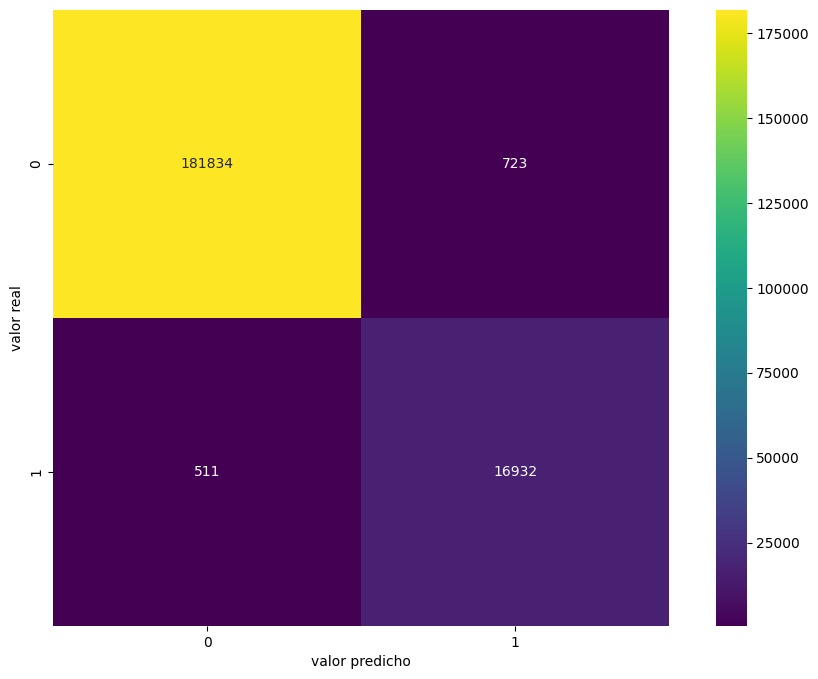

In [38]:
mat_lr_esta = confusion_matrix(y_test1, y_pred_test_esta2)

plt.figure(figsize = (12, 8))
sns.heatmap(mat_lr_esta, square=True, annot=True, fmt="d", cmap = "viridis")

plt.xlabel('valor predicho')
plt.ylabel('valor real')
plt.show()

In [18]:
# juntamos los dataframes de los dos modelos

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.999985,0.999943,0.999885,0.999914,0.999906,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I
0,0.993830,0.959048,0.970705,0.964841,0.961460,test,Decision tree Esta II
1,0.993959,0.959463,0.971984,0.965683,0.962371,train,Decision tree Esta II


In [19]:
# vamos a crearnos un dataframe 
importancia_predictores_esta = pd.DataFrame(
                            {'predictor': x_train1.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores_esta.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_esta

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,ratio_to_median_purchase_price,0.620914
0,distance_from_home,0.127552
5,used_pin_number,0.089158
4,used_chip,0.069373
6,online_order,0.039196
1,distance_from_last_transaction,0.031340
3,repeat_retailer,0.022468


Aquí vemos los resultados de la importancia de las variables predictoras, siendo el ratio del precio medio de compra la más importante para nuestro modelo a tener en cuenta para predecir si es o no fraude.

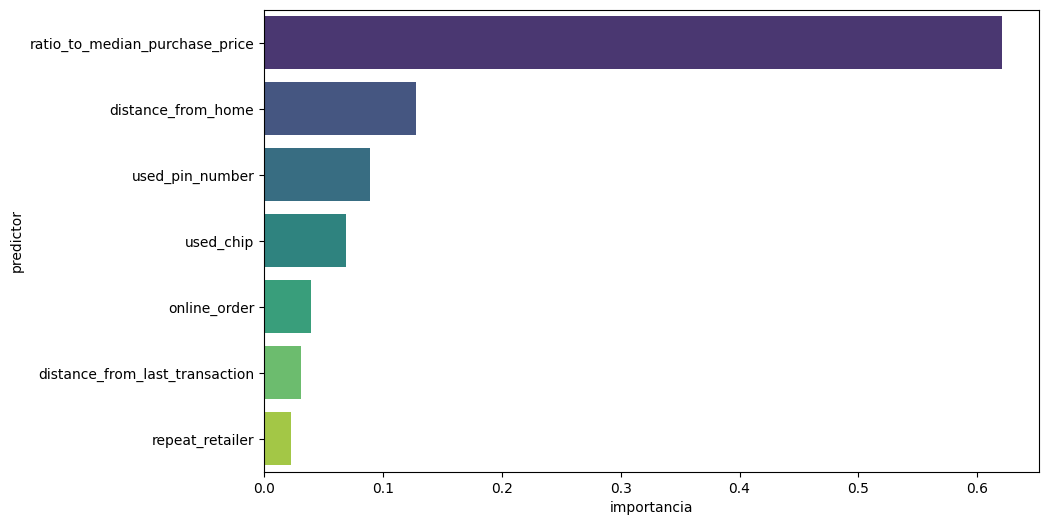

In [20]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores_esta, palette="viridis");
plt.show()

# CUARTO MODELO: RANDOM FOREST

In [21]:
X1 = df_esta.drop("fraud", axis = 1)
y1 = df_esta["fraud"]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state = 33)

Ajustamos los parámetros a los mejores que obtuvimos en el Decision Tree, ya que ampliando el espectro de posibilidades el modelo era interminable.

In [28]:
param = {"max_depth": [5], 
        "max_features": [3],
        "n_estimators": [50],
        "min_samples_split": [10, 15],
        "min_samples_leaf": [10,15]} 

In [29]:
gs_rf = GridSearchCV(
            estimator=RandomForestClassifier(random_state=29),
            param_grid= param, 
            cv=10, 
            verbose=-1) 

In [30]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=29),
             param_grid={'max_depth': [5], 'max_features': [3],
                         'min_samples_leaf': [10, 15],
                         'min_samples_split': [10, 15], 'n_estimators': [50]},
             verbose=-1)

In [31]:
bosque = gs.best_estimator_
bosque

DecisionTreeClassifier(max_depth=5, max_features=3, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

In [32]:
y_pred_test_rf = bosque.predict(x_test1)
y_pred_train_rf = bosque.predict(x_train1)

In [33]:
dt_results = metricas(y_test1, y_pred_test_rf,y_train1,  y_pred_train_rf, "Random Forest")
dt_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.993830,0.959048,0.970705,0.964841,0.961460,test,Random Forest
1,0.993959,0.959463,0.971984,0.965683,0.962371,train,Random Forest


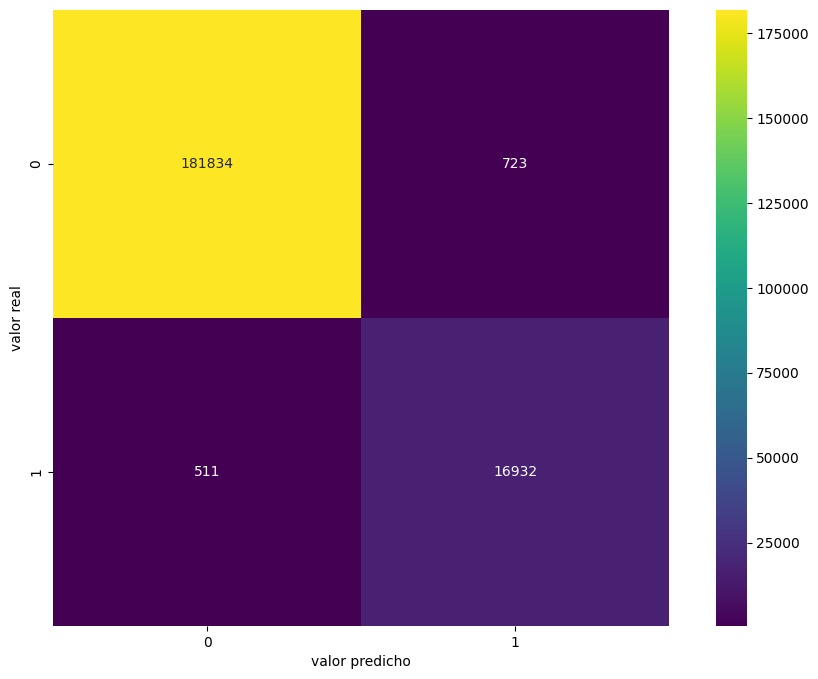

In [39]:
mat_lr = confusion_matrix(y_test1, y_pred_test_rf)

plt.figure(figsize = (12, 8))
sns.heatmap(mat_lr, square=True, annot=True, fmt="d", cmap = "viridis")

plt.xlabel('valor predicho')
plt.ylabel('valor real')
plt.show()

In [36]:
df_total = pd.concat([df_decision_results, dt_results], axis = 0)
df_total


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.999985,0.999943,0.999885,0.999914,0.999906,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I
0,0.993830,0.959048,0.970705,0.964841,0.961460,test,Decision tree Esta II
1,0.993959,0.959463,0.971984,0.965683,0.962371,train,Decision tree Esta II
0,0.993830,0.959048,0.970705,0.964841,0.961460,test,Random Forest
1,0.993959,0.959463,0.971984,0.965683,0.962371,train,Random Forest


Como vemos los resultados de los dos últimos modelos son iguales, ambos modelos predicen igual de bien, algo que ya esperábamos.